In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils import get_root_dir
from matplotlib import dates as mdates
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


### This Notebook will be used to test models for time-series forecasting on crime data

In [2]:
df_crime = pd.read_csv(os.path.join(get_root_dir(), 'data/processed/final.csv'))
df_crime.head()

,Major,Minor,Borough,Date,Count,Population,Count_Per_1000
0,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-04-01,6.0,182838,0.032816
1,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-05-01,5.0,182838,0.027347
2,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-06-01,11.0,182838,0.060163
3,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-07-01,10.0,182838,0.054693
4,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-08-01,6.0,182838,0.032816


In [3]:
total_crime_trend = df_crime.groupby('Date').sum(numeric_only=True)['Count_Per_1000']
total_crime_trend

Date
2010-04-01    268.322545
2010-05-01    274.519513
2010-06-01    277.427047
2010-07-01    281.972314
2010-08-01    261.862011
                 ...    
2023-07-01    273.811522
2023-08-01    262.543980
2023-09-01    263.757539
2023-10-01    280.749514
2023-11-01    271.461315
Name: Count_Per_1000, Length: 164, dtype: float64

<Axes: xlabel='Date'>

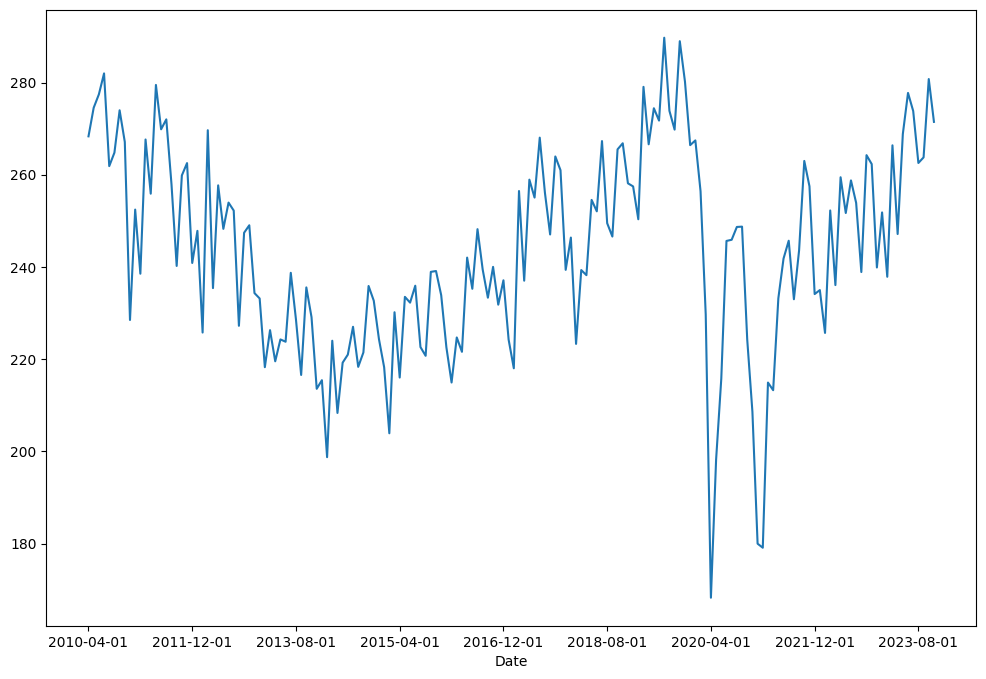

In [4]:
total_crime_trend.plot(figsize=(12,8))

In [5]:
df_train = total_crime_trend.iloc[:-12]
df_test = total_crime_trend.iloc[-12:]

<Axes: xlabel='Date'>

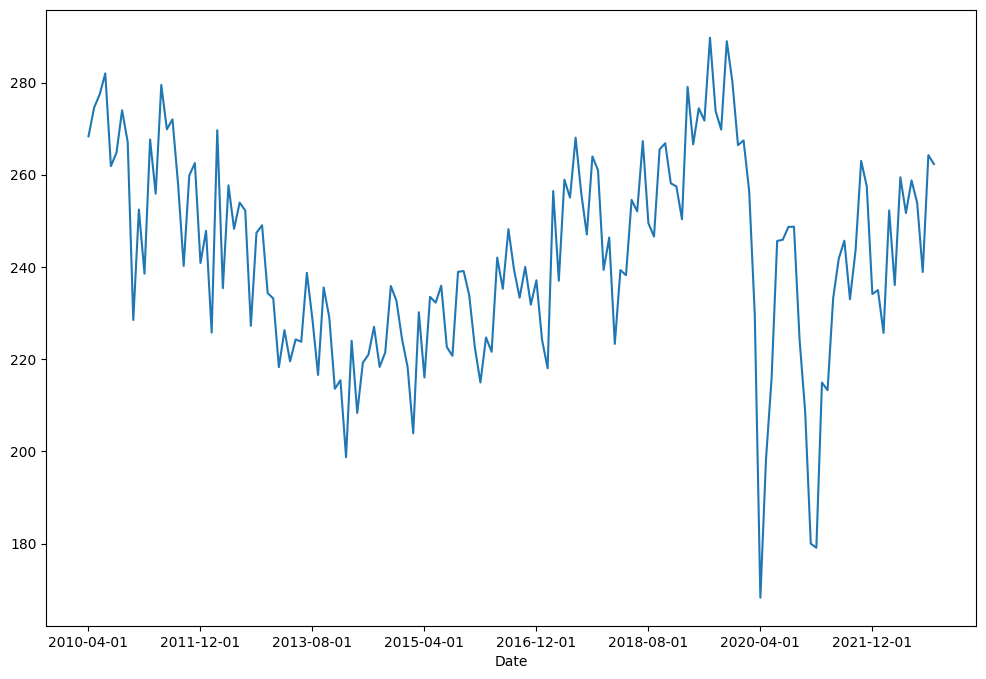

In [6]:
df_train.plot(figsize=(12, 8))

In [7]:
s_dec_additive = seasonal_decompose(x=df_train, model="additive", period=12)
s_dec_multiplicative = seasonal_decompose(x=df_train, model="multiplicative", period=12)

In [8]:
observed = s_dec_additive.observed
trend = s_dec_additive.trend
seasonal = s_dec_additive.seasonal
residual = s_dec_additive.resid

df_additive = pd.DataFrame({"observed":observed, "trend":trend, "seasonal":seasonal,"residual":residual})

In [9]:
observed = s_dec_multiplicative.observed
trend = s_dec_multiplicative.trend
seasonal = s_dec_multiplicative.seasonal
residual = s_dec_multiplicative.resid

df_multiplicative = pd.DataFrame({"observed":observed, "trend":trend, "seasonal":seasonal,"residual":residual})

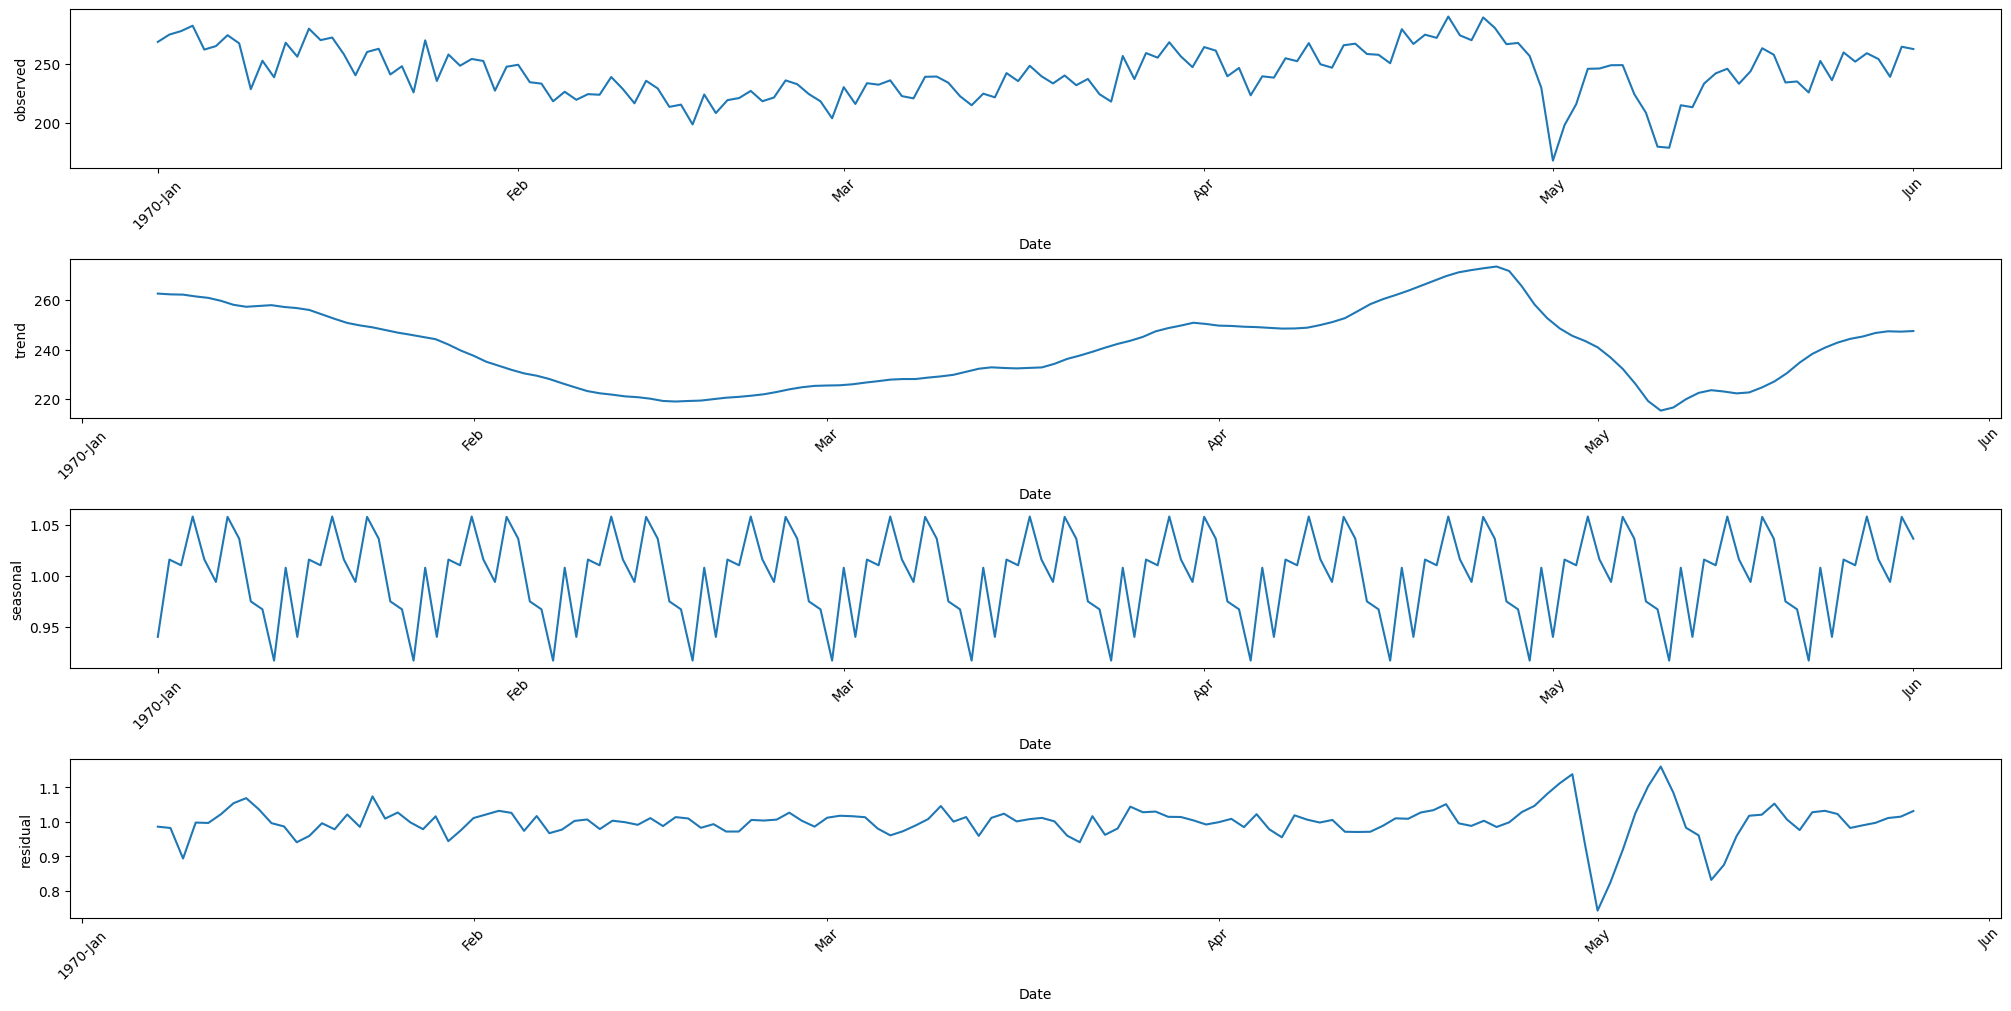

In [10]:
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10), constrained_layout=True)
for i, ax in enumerate(axes):
    ax = df_multiplicative.iloc[:,i].plot(ax=ax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(df_multiplicative.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

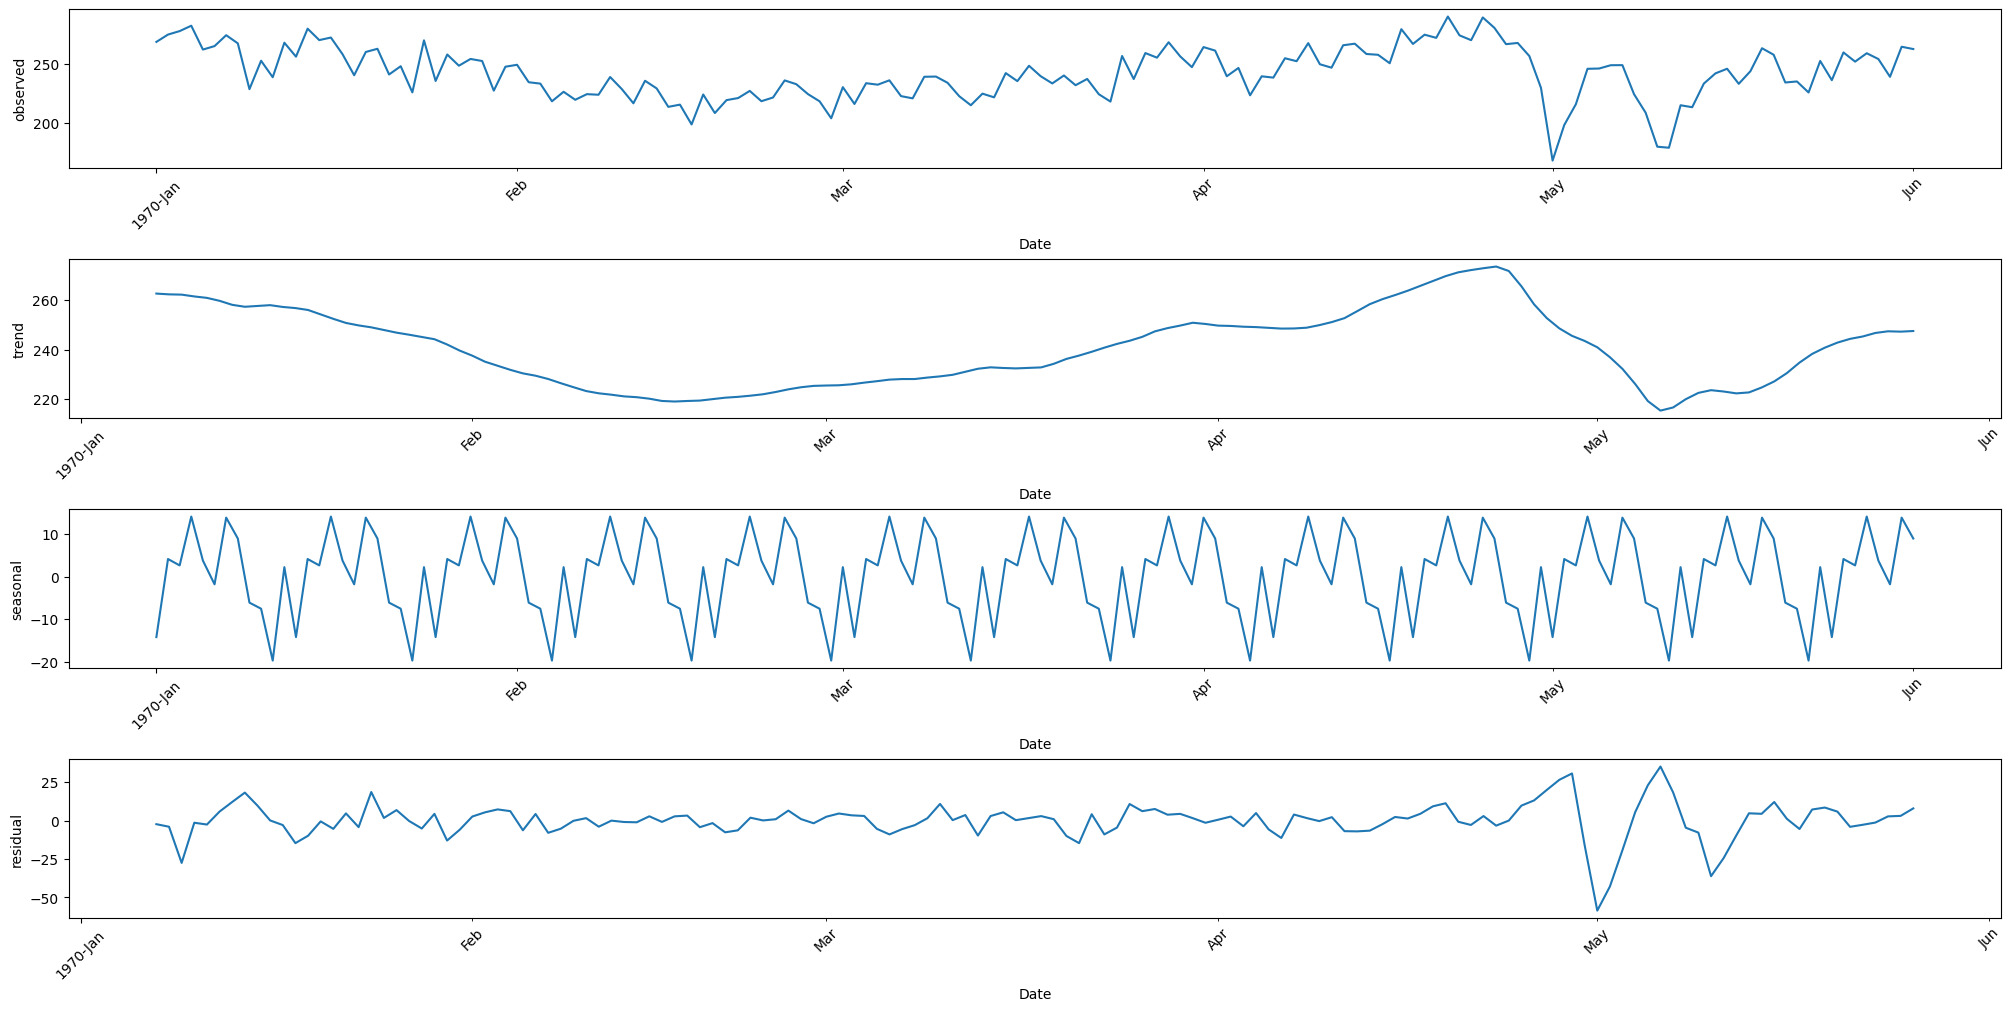

In [11]:
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(20, 10), constrained_layout=True)
for i, ax in enumerate(axes):
    ax = df_additive.iloc[:,i].plot(ax=ax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(df_additive.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

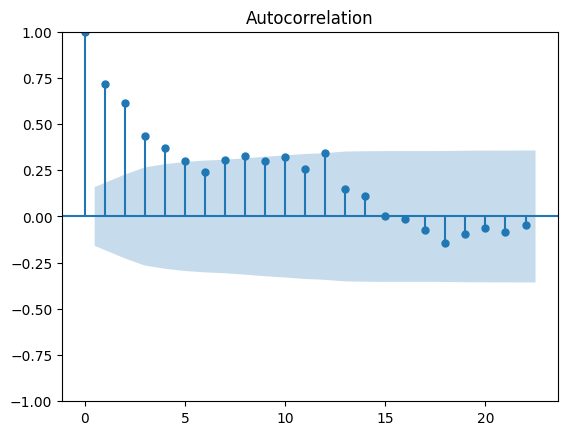

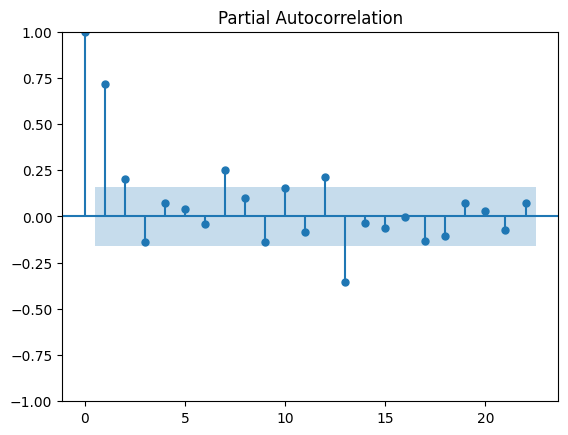

In [12]:
acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

## ADF test for stationarity

In [13]:
adf_test = adfuller(df_train)
print(f'p-value : {adf_test[1]}')

p-value : 0.13271648494443605


In [14]:
adf_test = adfuller(residual.dropna())
print(f'p-value : {adf_test[1]}')

p-value : 2.70516126887926e-18


## Transforming data to stationary

0.0021805770869732046


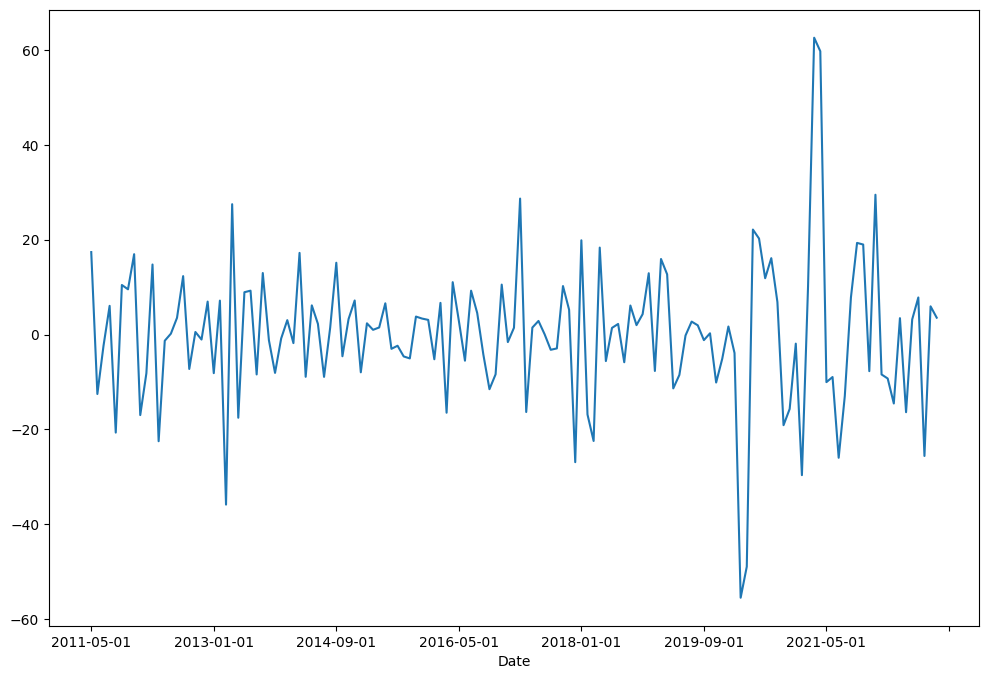

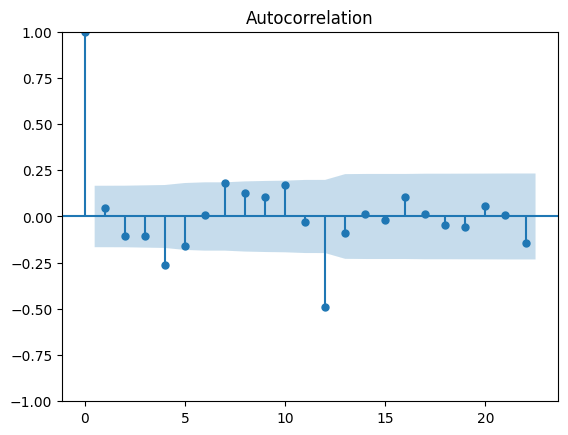

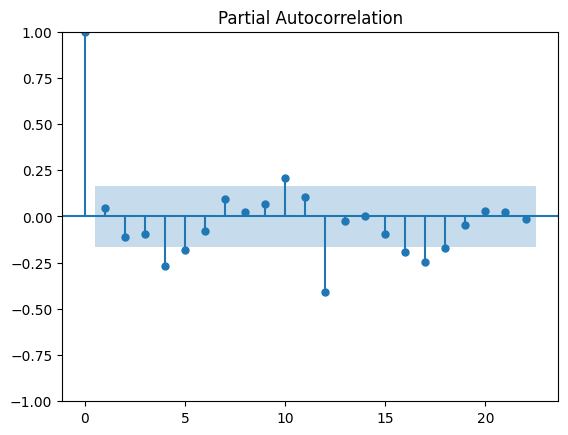

In [15]:
df_train_diff = df_train.diff(12).diff(1).dropna()

print(adfuller(df_train_diff)[1])

df_train_diff.plot(figsize=(12,8))

acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

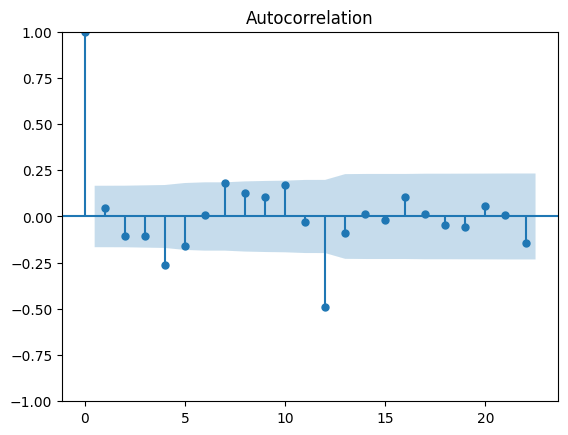

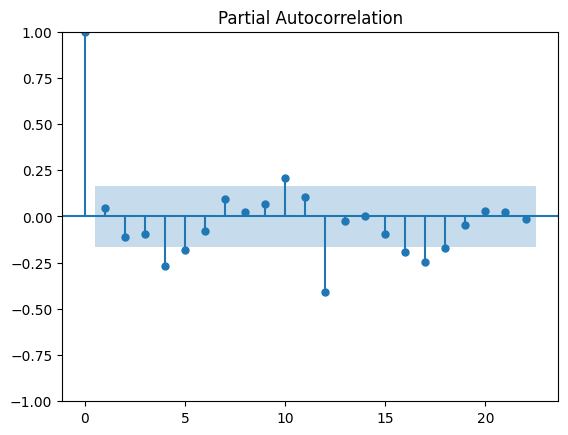

In [16]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

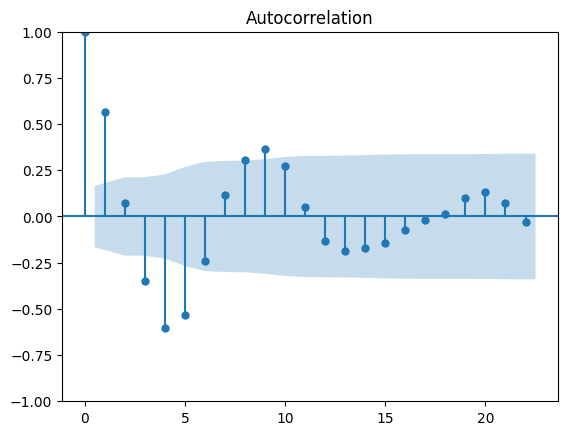

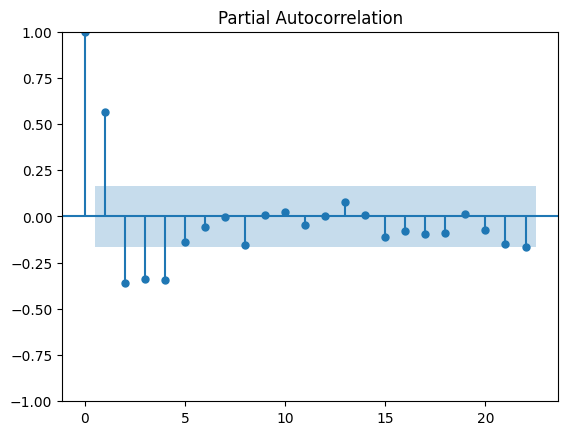

In [17]:
acf_diff = plot_acf(residual.dropna())

pacf_diff = plot_pacf(residual.dropna())

## Fit ARIMA Model

In [18]:
model = ARIMA(residual, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  152
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 225.725
Date:                Mon, 22 Apr 2024   AIC                           -445.450
Time:                        11:43:20   BIC                           -436.398
Sample:                    04-01-2010   HQIC                          -441.772
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0691      0.046      1.490      0.136      -0.022       0.160
ar.L2         -0.0910      0.060     -1.506      0.132      -0.209       0.027
sigma2         0.0020      0.000     13.383      0.0

/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Check Model Residuals

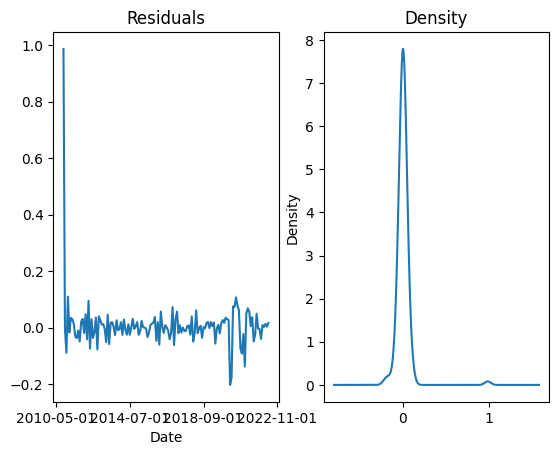

In [19]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

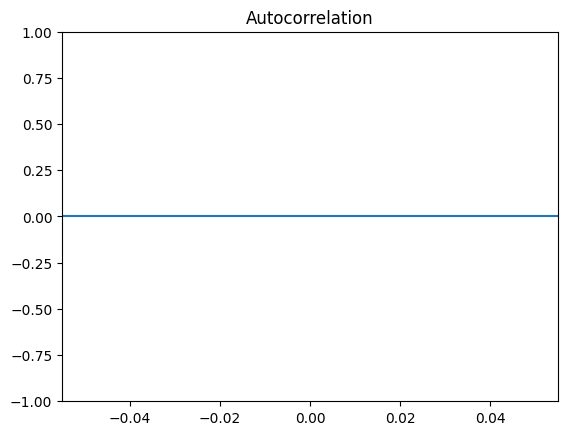

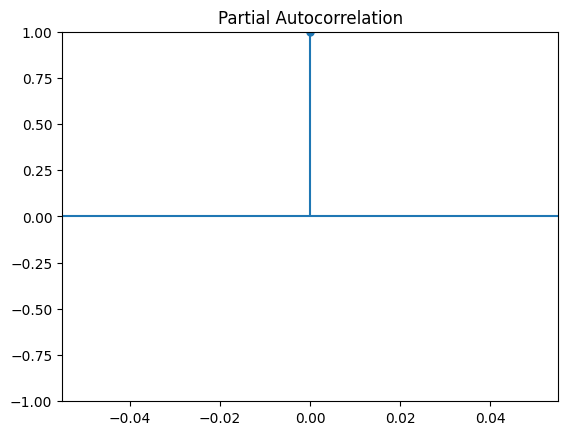

In [20]:
acf_resid = plot_acf(residuals)

pacf_resid = plot_pacf(residuals)

## Forecasting with fitted model

In [21]:
df = pd.DataFrame(total_crime_trend)


<Axes: xlabel='Date'>

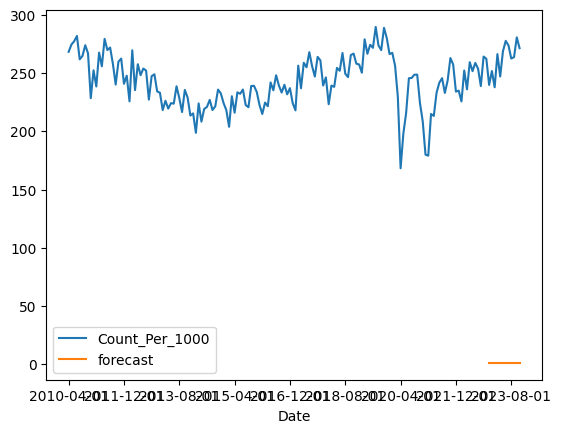

In [22]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast'] = [None]*len(df_train) + list(forecast_test)

df.plot()

In [23]:
forecast_test

2022-12-01    1.030810
2023-01-01    1.030811
2023-02-01    1.030811
2023-03-01    1.030811
2023-04-01    1.030811
2023-05-01    1.030811
2023-06-01    1.030811
2023-07-01    1.030811
2023-08-01    1.030811
2023-09-01    1.030811
2023-10-01    1.030811
2023-11-01    1.030811
Freq: MS, Name: predicted_mean, dtype: float64

## Auto Arima on Residuals

In [24]:
df_train

Date
2010-04-01    268.322545
2010-05-01    274.519513
2010-06-01    277.427047
2010-07-01    281.972314
2010-08-01    261.862011
                 ...    
2022-07-01    258.768760
2022-08-01    253.894302
2022-09-01    238.891701
2022-10-01    264.242894
2022-11-01    262.308447
Name: Count_Per_1000, Length: 152, dtype: float64

In [25]:
model = pm.auto_arima(df_train, 
                      m=12,                 # frequency of series                      
                      seasonal=True,        # TRUE if seasonal series
                      d=None,               # let model determine 'd'
                      test='adf',           # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12,   # maximum p and q
                      D=None,               # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1274.443, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1225.730, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1241.060, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1272.444, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1259.040, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1209.077, Time=0.40 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1207.530, Time=0.22 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1225.388, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1209.052, Time=0.32 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=1210.962, Time=0.70 sec
 ARIMA(0,1,0)(2,0,0)[12]             : 

In [26]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  152
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -599.765
Date:                            Mon, 22 Apr 2024   AIC                           1205.530
Time:                                    11:43:32   BIC                           1214.582
Sample:                                04-01-2010   HQIC                          1209.208
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3592      0.052      6.948      0.000       0.258       0.461
ar.S.L24       0.3882      0.068   

<Axes: >

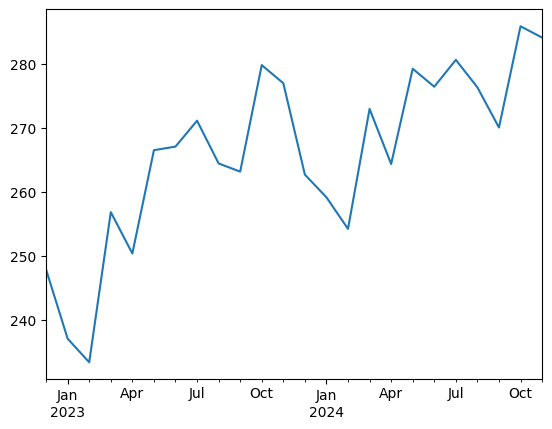

In [27]:
forecast_test = model.predict(n_periods=24)

# df['forecast'] = [None]*len(df_train) + list(forecast_test)

# df['2020-01-01':].plot()

forecast_test.plot()

<Axes: xlabel='Date'>

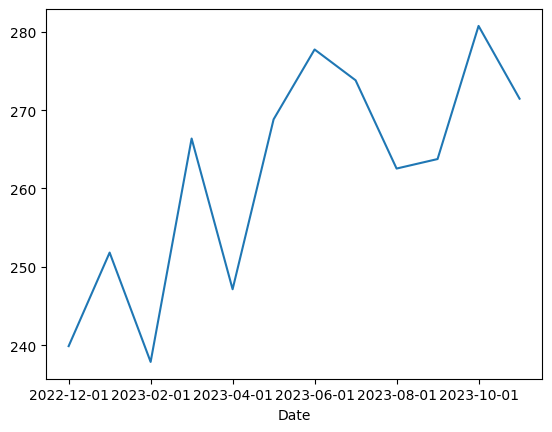

In [28]:

df_test.plot()

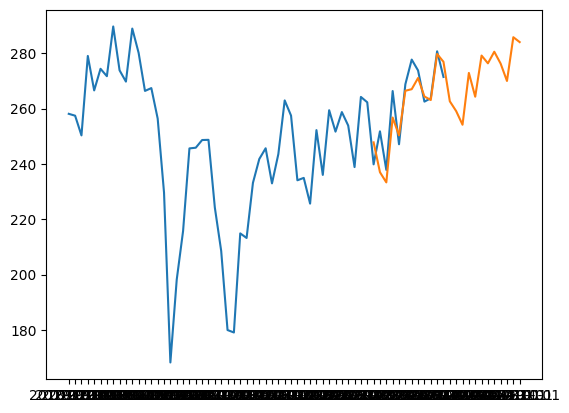

In [32]:
plt.plot(total_crime_trend[-60:])
plt.plot(forecast_test)

In [31]:
forecast_test = forecast_test.reset_index()#['index'].dt.strftime('%Y-%m-%d')
forecast_test['index'] = forecast_test['index'].dt.strftime('%Y-%m-%d')
forecast_test.set_index('index', inplace=True)
forecast_test

,0
index,
2022-12-01,247.828069
2023-01-01,237.029180
2023-02-01,233.350419
2023-03-01,256.799718
2023-04-01,250.342027
2023-05-01,266.479866
2023-06-01,267.041859
2023-07-01,271.086917
2023-08-01,264.407964


## Modelling each crime

In [40]:
df_crime['Major'].nunique(), np.ceil(df_crime['Major'].nunique()/2)

(11, 6.0)

In [37]:
fig, axes = plt.subplots(nrows=int(np.ceil(df_crime['Major'].nunique()/2)), ncols=2, figsize=(10, df_crime['Major'].nunique() + np.mod(df_crime['Major'].nunique(), 2)), constrained_layout=True)
fig.suptitle('Crime Trends by Borough; Unique to Historical Data', fontsize=20)

if np.mod(df_crime['Major'].nunique(), 2):
    axes[-1, -1].set_axis_off()

for index, row in df_temp.iterrows():

    ax=axes[int(np.floor(index/2)), np.mod(index, 2)]
    row[1:].plot(ax=ax, title=row.iloc[0])

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2153932715.py, line 1)

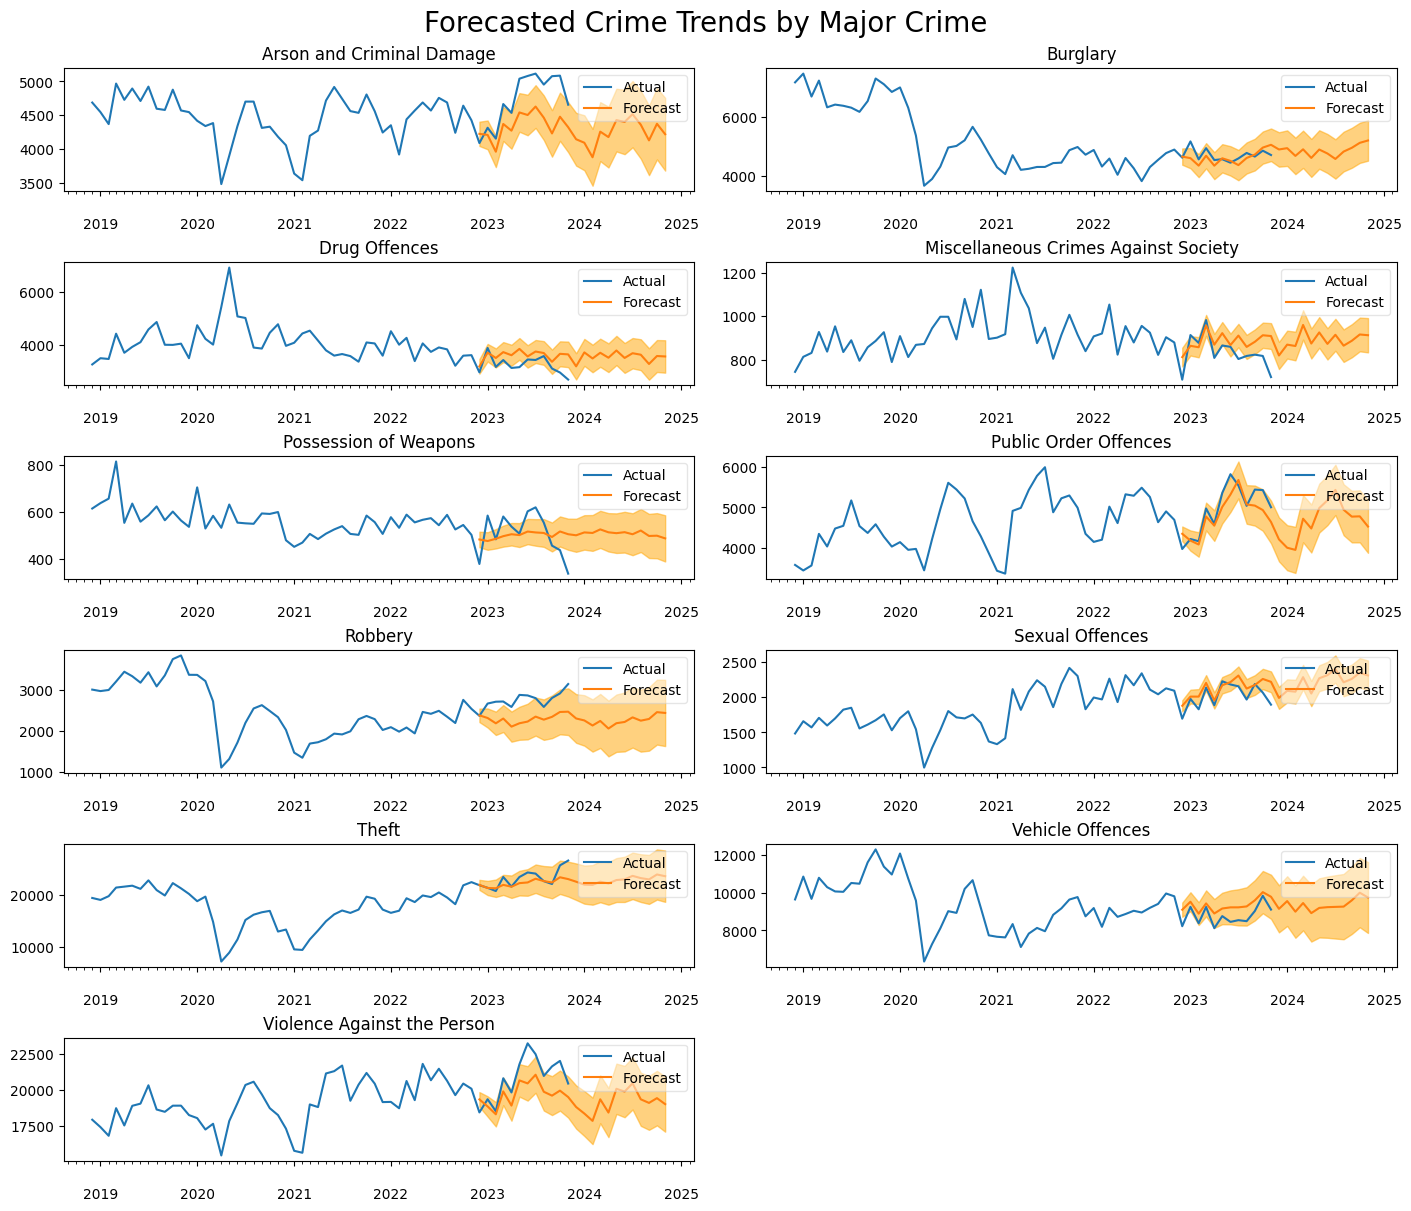

In [101]:
fig, axes = plt.subplots(nrows=int(np.ceil(df_crime['Major'].nunique()/2)), ncols=2, figsize=(14, df_crime['Major'].nunique() + np.mod(df_crime['Major'].nunique(), 2)), constrained_layout=True)
fig.suptitle('Forecasted Crime Trends by Major Crime', fontsize=20)

if np.mod(df_crime['Major'].nunique(), 2):
    axes[-1, -1].set_axis_off()

for index, major in enumerate(df_crime['Major'].unique()):
    
    # if index == 1:
    #     break

    crime_trend = df_crime[df_crime['Major']==major].groupby('Date').sum(numeric_only=True)['Count']
    crime_train = crime_trend.iloc[:-12]
    crime_test = crime_trend.iloc[-12:]

    model = pm.auto_arima(crime_train, 
                          m=12,                 # frequency of series                      
                          seasonal=True,        # TRUE if seasonal series
                          d=None,               # let model determine 'd'
                          test='adf',           # use adftest to find optimal 'd'
                          start_p=0, start_q=0, # minimum p and q
                          max_p=12, max_q=12,   # maximum p and q
                          D=None,               # let model determine 'D'
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    
    forecast_test, conf_int = model.predict(n_periods=24, return_conf_int=True, alpha=0.5)
    forecast_test = forecast_test.reset_index()
    forecast_test['index'] = forecast_test['index'].dt.strftime('%Y-%m-%d')
    forecast_test.set_index('index', inplace=True)
    forecast_test

    crime_trend.index = pd.to_datetime(crime_trend.index)
    forecast_test.index = pd.to_datetime(forecast_test.index)

    conf_lower = pd.Series(conf_int[:,0], index=forecast_test.index)
    conf_upper = pd.Series(conf_int[:,1], index=forecast_test.index)

    ax=axes[int(np.floor(index/2)), np.mod(index, 2)]
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.set_title(major)
    ax.plot(crime_trend[-60:])
    ax.plot(forecast_test)
    ax.fill_between(x=forecast_test.index, y1=conf_lower, y2=conf_upper, color='orange', alpha=0.5)
    ax.legend(['Actual', 'Forecast'], framealpha=0.5, loc='upper right')
    

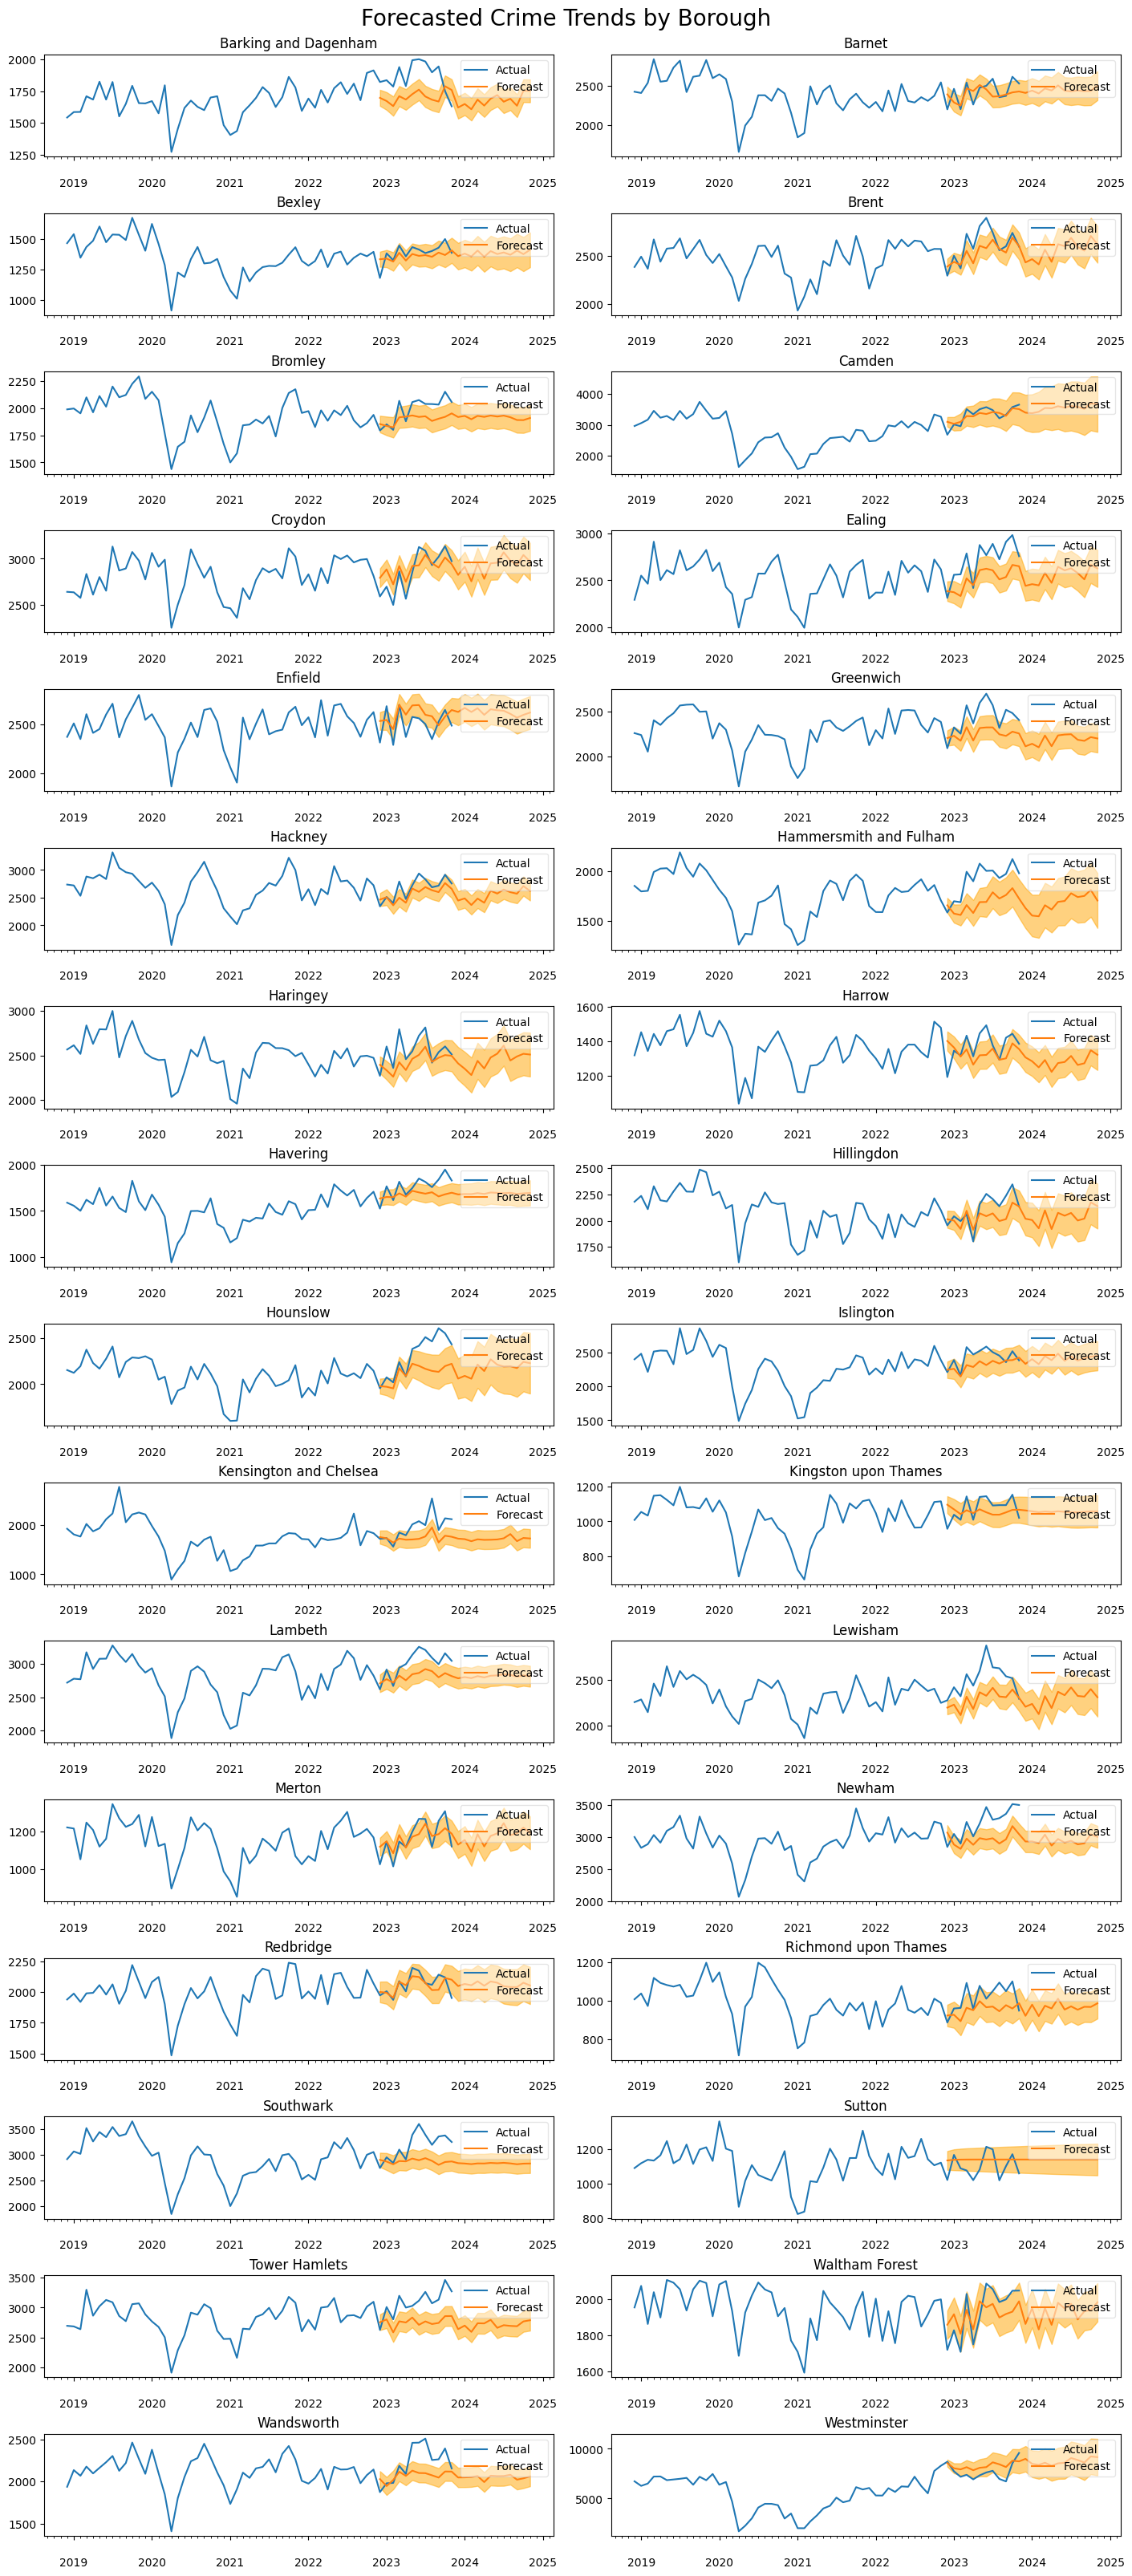

In [103]:
fig, axes = plt.subplots(nrows=int(np.ceil(df_crime['Borough'].nunique()/2)), ncols=2, figsize=(14, df_crime['Borough'].nunique() + np.mod(df_crime['Borough'].nunique(), 2)), constrained_layout=True)
fig.suptitle('Forecasted Crime Trends by Borough', fontsize=20)

if np.mod(df_crime['Borough'].nunique(), 2):
    axes[-1, -1].set_axis_off()

for index, borough in enumerate(df_crime['Borough'].unique()):
    
    # if index == 1:
    #     break

    crime_trend = df_crime[df_crime['Borough']==borough].groupby('Date').sum(numeric_only=True)['Count']
    crime_train = crime_trend.iloc[:-12]
    crime_test = crime_trend.iloc[-12:]

    model = pm.auto_arima(crime_train, 
                          m=12,                 # frequency of series                      
                          seasonal=True,        # TRUE if seasonal series
                          d=None,               # let model determine 'd'
                          test='adf',           # use adftest to find optimal 'd'
                          start_p=0, start_q=0, # minimum p and q
                          max_p=12, max_q=12,   # maximum p and q
                          D=None,               # let model determine 'D'
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    
    forecast_test, conf_int = model.predict(n_periods=24, return_conf_int=True, alpha=0.5)
    forecast_test = forecast_test.reset_index()
    forecast_test['index'] = forecast_test['index'].dt.strftime('%Y-%m-%d')
    forecast_test.set_index('index', inplace=True)
    forecast_test

    crime_trend.index = pd.to_datetime(crime_trend.index)
    forecast_test.index = pd.to_datetime(forecast_test.index)

    conf_lower = pd.Series(conf_int[:,0], index=forecast_test.index)
    conf_upper = pd.Series(conf_int[:,1], index=forecast_test.index)

    ax=axes[int(np.floor(index/2)), np.mod(index, 2)]
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.set_title(borough)
    ax.plot(crime_trend[-60:])
    ax.plot(forecast_test)
    ax.fill_between(x=forecast_test.index, y1=conf_lower, y2=conf_upper, color='orange', alpha=0.5)
    ax.legend(['Actual', 'Forecast'], framealpha=0.5, loc='upper right')
    

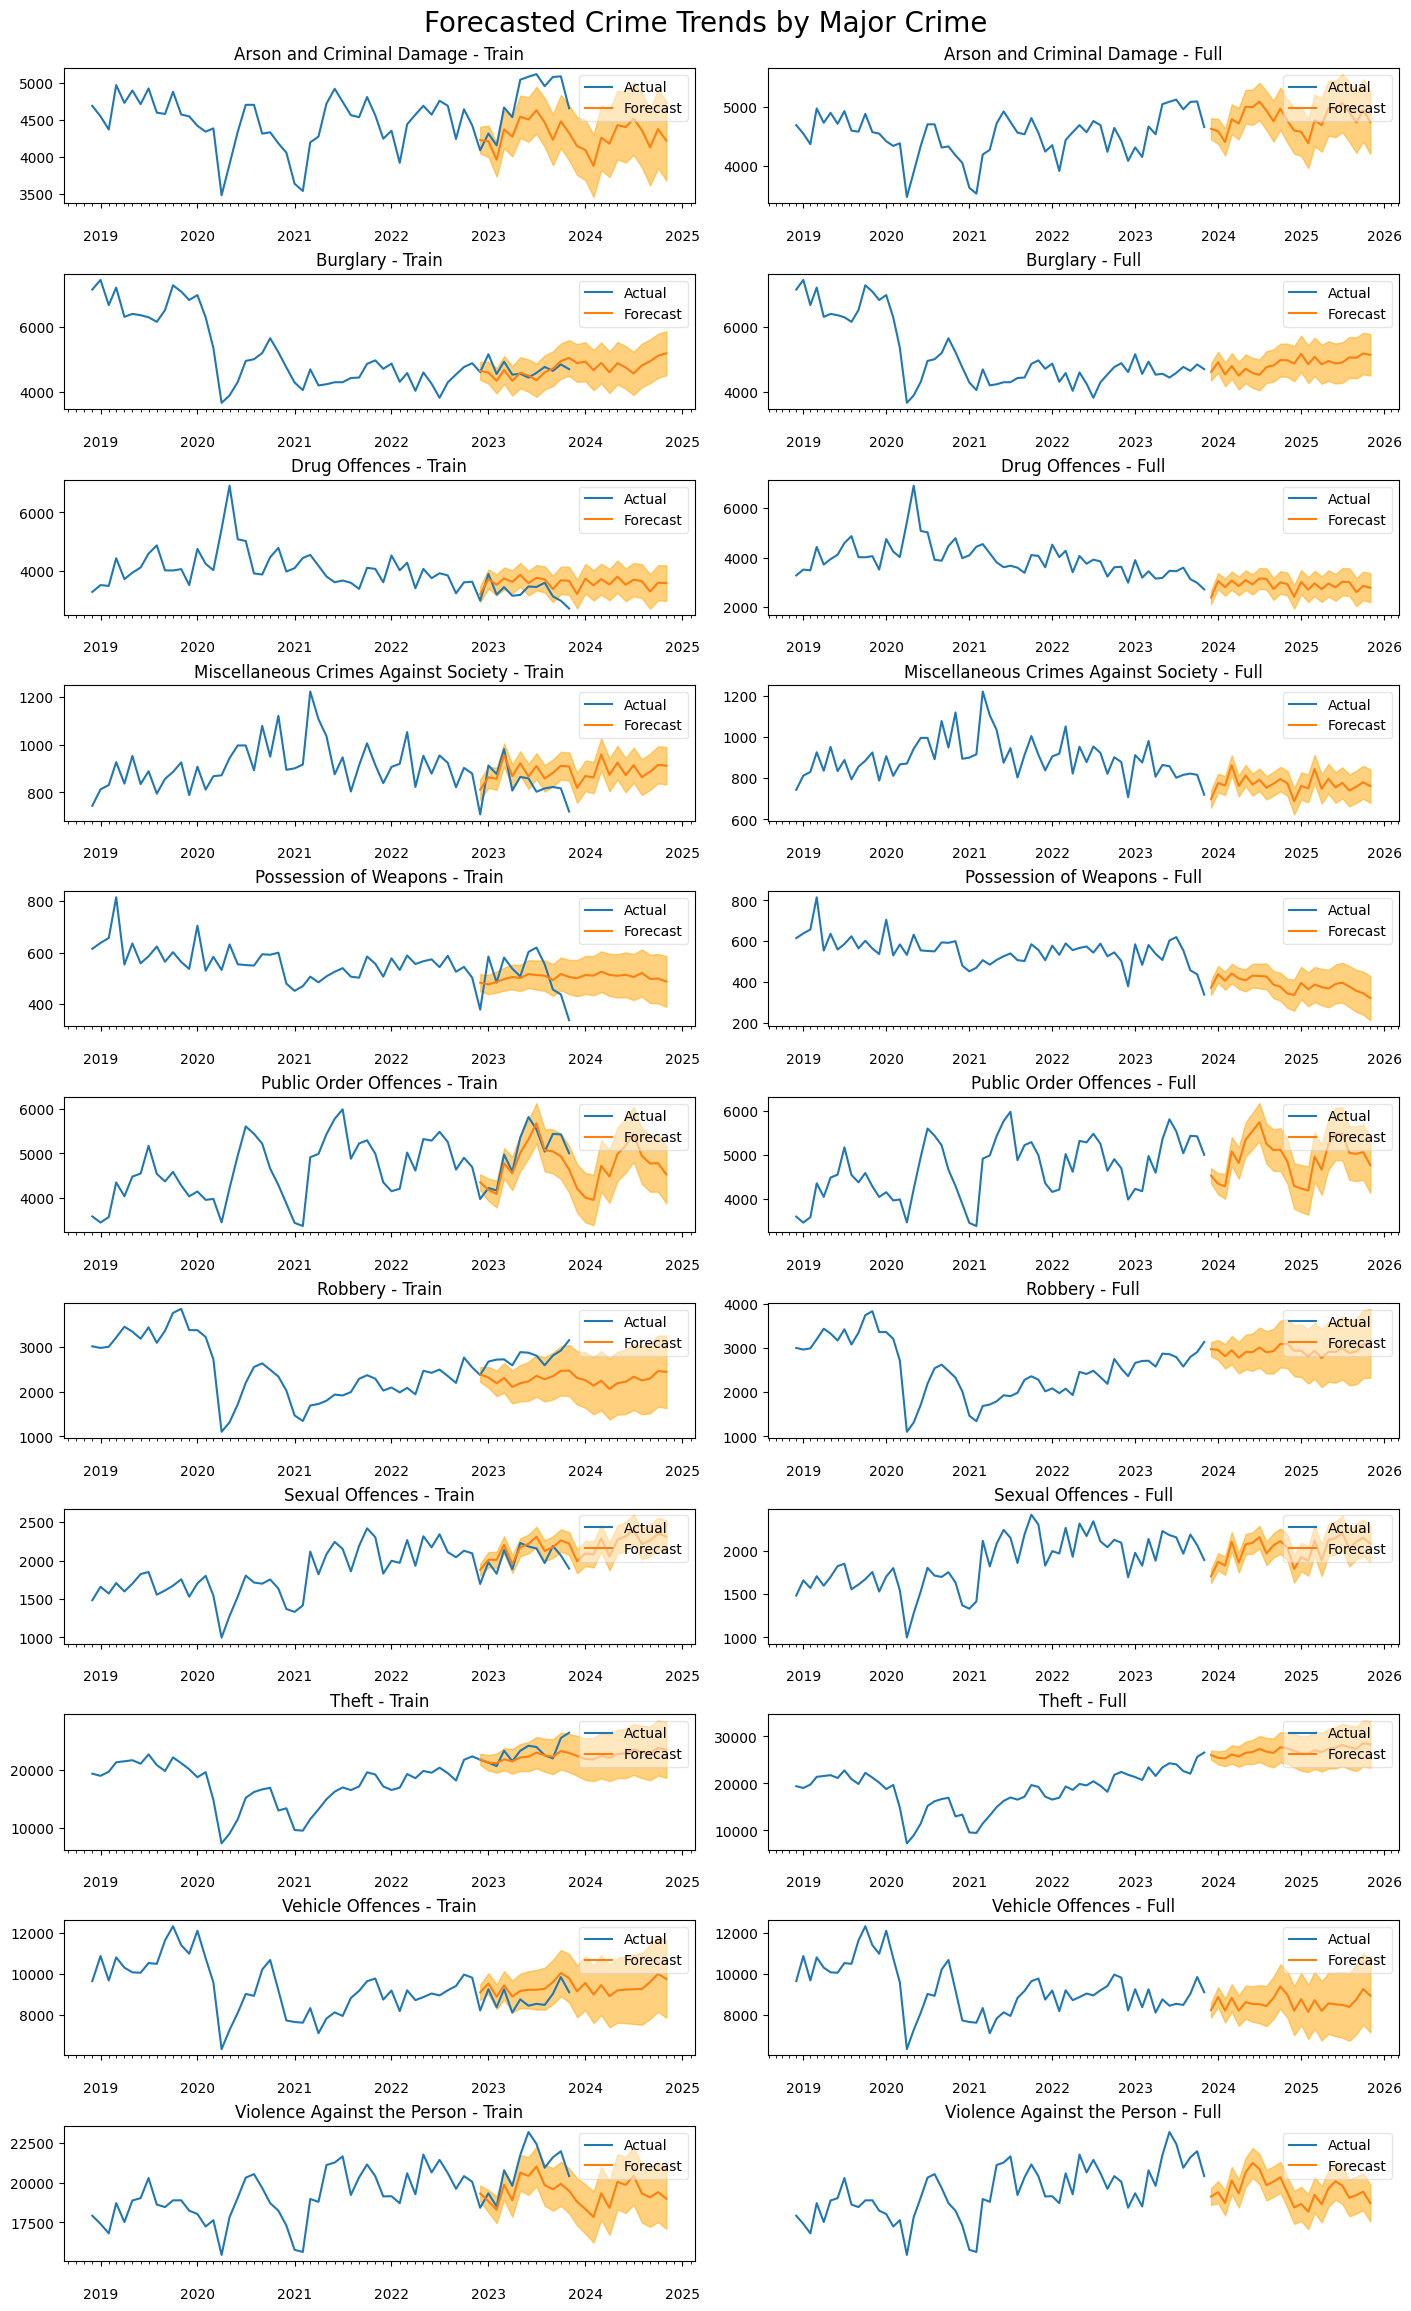

In [108]:
fig, axes = plt.subplots(nrows=int(np.ceil(df_crime['Major'].nunique())), ncols=2, figsize=(14, df_crime['Major'].nunique() * 2 + np.mod(df_crime['Major'].nunique(), 2)), constrained_layout=True)
fig.suptitle('Forecasted Crime Trends by Major Crime', fontsize=20)

# if np.mod(df_crime['Major'].nunique(), 2):
#     axes[-1, -1].set_axis_off()

for index, major in enumerate(df_crime['Major'].unique()):
    
    # if index == 2:
    #     break

    crime_trend = df_crime[df_crime['Major']==major].groupby('Date').sum(numeric_only=True)['Count']
    crime_train = crime_trend.iloc[:-12]
    crime_test = crime_trend.iloc[-12:]

    model = pm.auto_arima(crime_train, 
                          m=12,                 # frequency of series                      
                          seasonal=True,        # TRUE if seasonal series
                          d=None,               # let model determine 'd'
                          test='adf',           # use adftest to find optimal 'd'
                          start_p=0, start_q=0, # minimum p and q
                          max_p=12, max_q=12,   # maximum p and q
                          D=None,               # let model determine 'D'
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    
    forecast_test, conf_int = model.predict(n_periods=24, return_conf_int=True, alpha=0.5)
    forecast_test = forecast_test.reset_index()
    forecast_test['index'] = forecast_test['index'].dt.strftime('%Y-%m-%d')
    forecast_test.set_index('index', inplace=True)
    forecast_test

    crime_trend.index = pd.to_datetime(crime_trend.index)
    forecast_test.index = pd.to_datetime(forecast_test.index)

    conf_lower = pd.Series(conf_int[:,0], index=forecast_test.index)
    conf_upper = pd.Series(conf_int[:,1], index=forecast_test.index)

    ax=axes[index, 0]
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.set_title(f'{major} - Train')
    ax.plot(crime_trend[-60:])
    ax.plot(forecast_test)
    ax.fill_between(x=forecast_test.index, y1=conf_lower, y2=conf_upper, color='orange', alpha=0.5)
    ax.legend(['Actual', 'Forecast'], framealpha=0.5, loc='upper right')

    # Fitted on full data
    model.fit(crime_trend)
    forecast_test, conf_int = model.predict(n_periods=24, return_conf_int=True, alpha=0.5)
    forecast_test = forecast_test.reset_index()
    forecast_test['index'] = forecast_test['index'].dt.strftime('%Y-%m-%d')
    forecast_test.set_index('index', inplace=True)
    forecast_test

    crime_trend.index = pd.to_datetime(crime_trend.index)
    forecast_test.index = pd.to_datetime(forecast_test.index)

    conf_lower = pd.Series(conf_int[:,0], index=forecast_test.index)
    conf_upper = pd.Series(conf_int[:,1], index=forecast_test.index)

    ax=axes[index, 1]
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.set_title(f'{major} - Full')
    ax.plot(crime_trend[-60:])
    ax.plot(forecast_test)
    ax.fill_between(x=forecast_test.index, y1=conf_lower, y2=conf_upper, color='orange', alpha=0.5)
    ax.legend(['Actual', 'Forecast'], framealpha=0.5, loc='upper right')
